In [ ]:
!pip install lifelines
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import shap
from sklearn.metrics import r2_score, mean_squared_error
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce

##Data Preparation

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/HCT Survival Prediction/train.csv')
train,test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
data.shape

(28800, 60)

In [ ]:
data.isnull().sum()

,0
ID,0
dri_score,154
psych_disturb,2062
cyto_score,8068
diabetes,2119
hla_match_c_high,4620
hla_high_res_8,5829
tbi_status,0
arrhythmia,2202
hla_low_res_6,3270


In [ ]:
train.shape

(23040, 60)

In [ ]:
train_without_efs = train.drop(['efs','ID'], axis=1)
test_without_efs = test.drop(['efs','ID'], axis=1)

##EDA

###Race Distribution

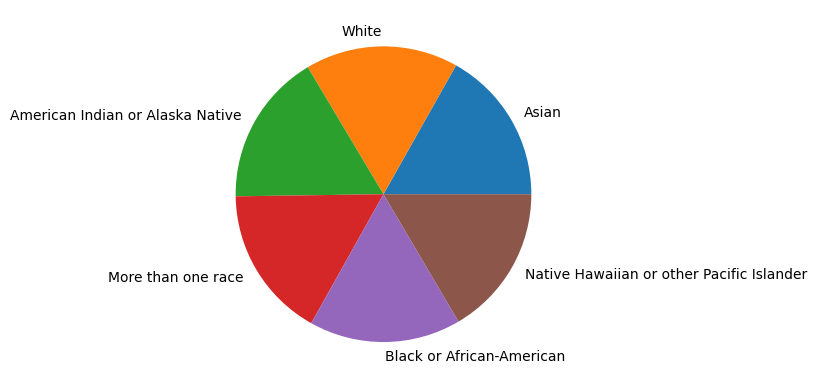

In [ ]:
counts = train['race_group'].value_counts()
plt.pie(counts, labels=counts.index)
plt.show()

In [ ]:
counts

,count
race_group,
Asian,3879
White,3853
American Indian or Alaska Native,3841
More than one race,3835
Black or African-American,3824
Native Hawaiian or other Pacific Islander,3808


Since no country in the world has these six race groups represented equally, it's evident that some groups have been either upsampled or downsampled in the dataset.

###Distribution of Continuous Features

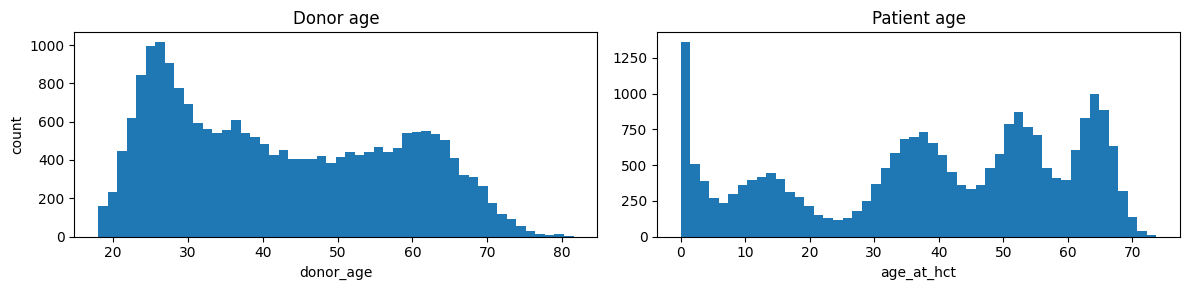

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.hist(train['donor_age'], bins=50)
plt.title('Donor age')
plt.xlabel('donor_age')
plt.ylabel('count')
plt.subplot(1, 2, 2)
plt.title('Patient age')
plt.hist(train['age_at_hct'], bins=50)
plt.xlabel('age_at_hct')
plt.tight_layout()
plt.show()

Only two features contain continuous data: donor age and age_at_hct (probably patient age). The histogram of patient age reveals five distinct peaks, indicating a multimodal distribution. This pattern is highly unusual and likely results from the synthetic data generation process.

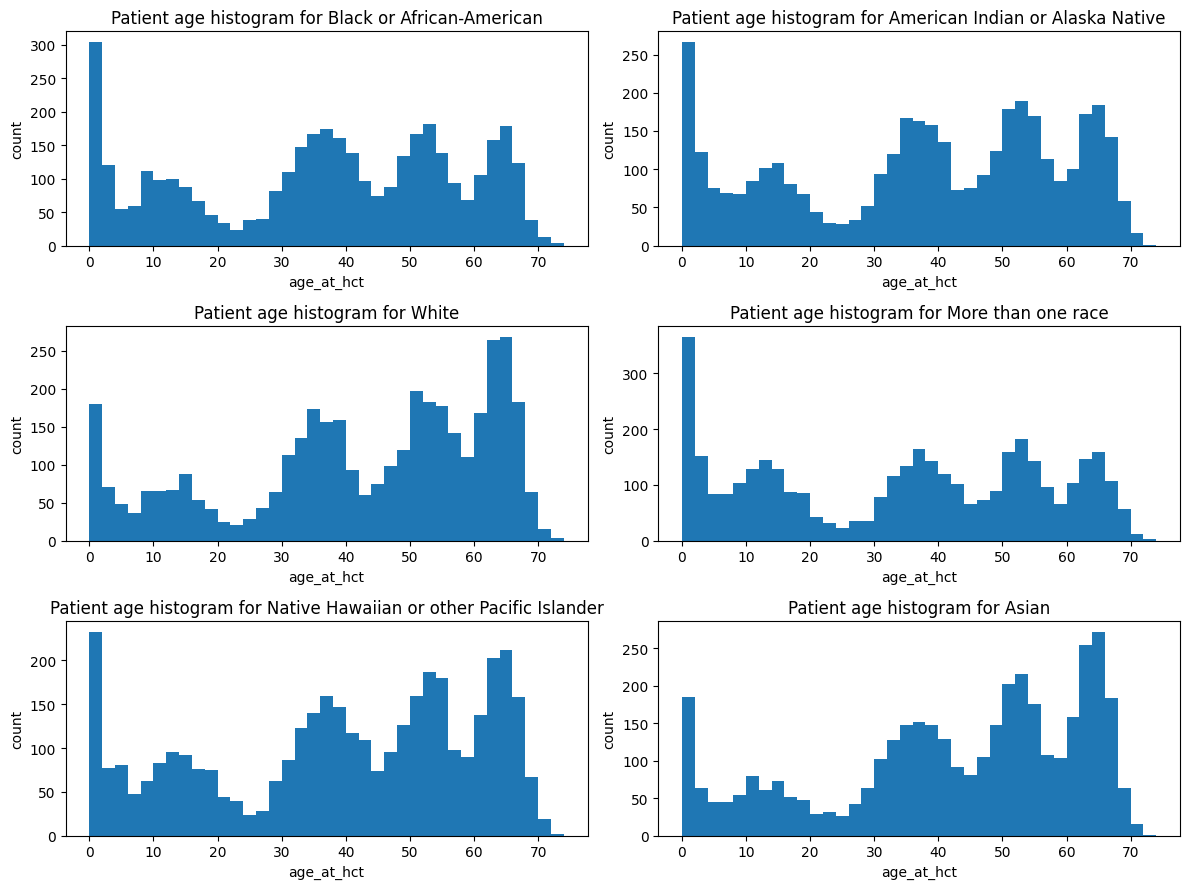

In [ ]:
_, axs = plt.subplots(3, 2, figsize=(12, 9))
for race_group, ax in zip(train['race_group'].unique(), axs.ravel()):
    ax.hist(train.age_at_hct[train.race_group == race_group],bins=np.linspace(0, 74, 38))
    ax.set_title(f'Patient age histogram for {race_group}')
    ax.set_xlabel('age_at_hct')
    ax.set_ylabel('count')
plt.tight_layout()
plt.show()

Patient age distribution has the same five modes in every race group

###How efs_time varies across each race

In [ ]:
groups = train.groupby('race_group')['efs_time']

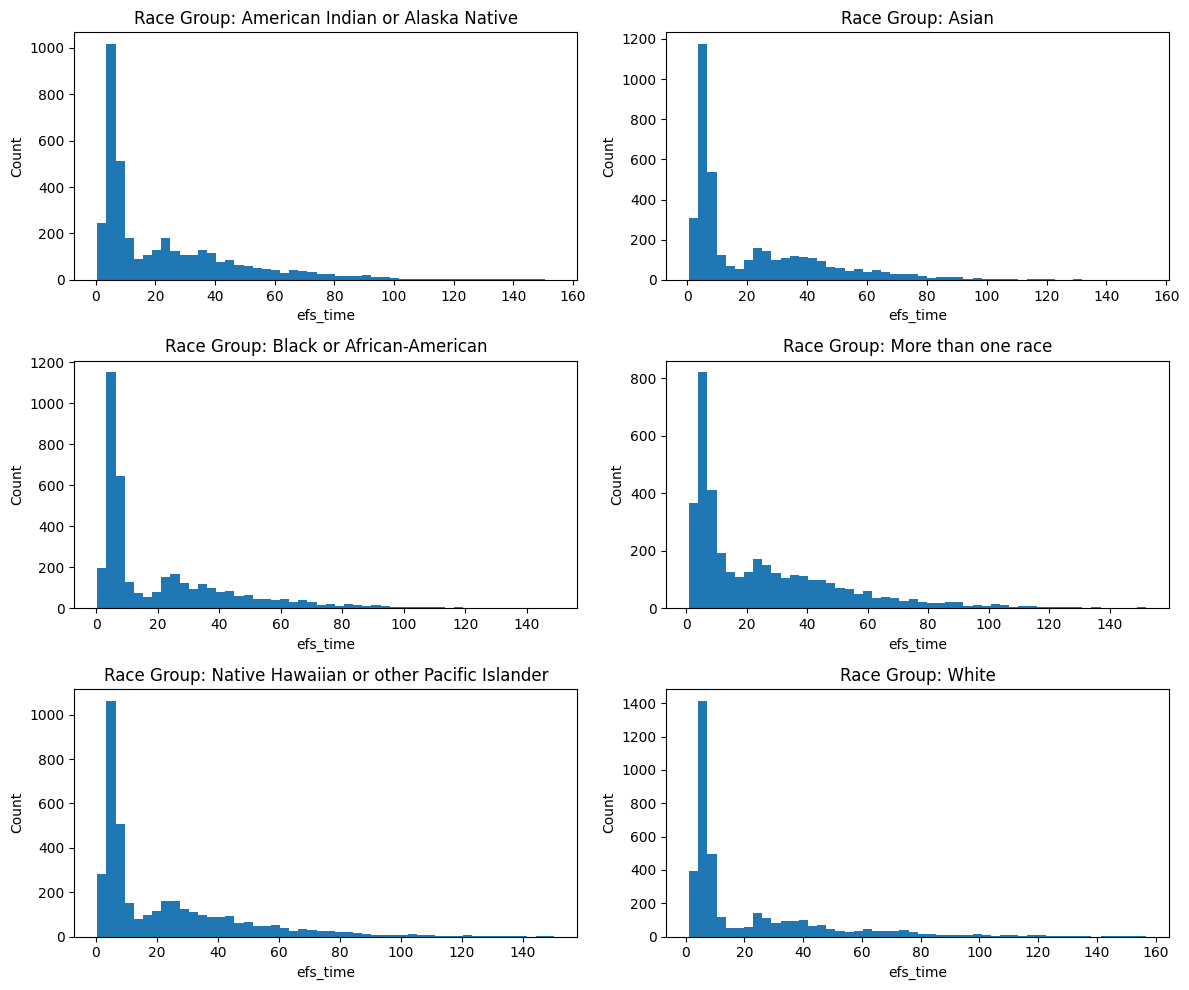

In [ ]:
groups = train.groupby('race_group')['efs_time']

plt.figure(figsize=(12, 10))
for i, (grp_name, grp_vals) in enumerate(groups, start=1):
    plt.subplot(3, 2, i)
    plt.hist(grp_vals, bins=50)
    plt.title(f'Race Group: {grp_name}')
    plt.xlabel('efs_time')
    plt.ylabel('Count')

# 3) tidy up spacing and show
plt.tight_layout()
plt.show()

Observation:
- For most patients across all racial groups, their health condition tends to worsen within the first 20 months.

- Those identifying as "more than one race" have the highest chance of remaining stable, whereas white patients have the lowest.

##Model Training

###Linear Model

In [ ]:
cat_features = list(train.select_dtypes(object).columns)

In [ ]:
preproc = ColumnTransformer([('ohe',
                              OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore'),
                              cat_features),],
                              remainder=SimpleImputer(strategy='median'),
                              verbose_feature_names_out=False
                            ).set_output(transform='pandas')
features = [f for f in test.columns if f != 'ID']
X_train = preproc.fit_transform(train[features])
X_test = preproc.transform(test[features])

model = CoxPHFitter(penalizer=.01)

feats = [f for f in X_train.columns if f not in ['gvhd_proph_FK+- others(not MMF,MTX)']]

model.fit(X_train[feats], duration_col='efs_time', event_col='efs')
model.print_summary()

y_pred = model.predict_partial_hazard(X_test)

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10585 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12455
   partial log-likelihood = -118353.08
         time fit was run = 2025-04-23 20:08:31 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
dri_score_High - TED AML case <missing cytogenetics         -0.33      0.72      0.04           -0.42           -0.24                0.66                0.78
dri_score_Intermediate                                      -0.40      0.67      0.03           -0.45           -0.35                0.64                0.71
dri_score_Intermediate - TED AML case <missing cytogenetics -0.32      0.73      0.07           -0.46           -0.18                0.63                0.84
dri_score_Low                                               -0.33      0.72      0.04           -0.41           -0.25                0.67                0.78
dri_score_Missing disease status                            -0.46      0.63      0.57           -1.58            0.66                0.21                1.94
dri_score_N/A - disease not classifiable                    -0.33      0.72      0.11           -0.54           -0.12                0.58                0.88
dri_score_N/A - non-malignant indication                    -0.34      0.71      0.04           -0.42           -0.26                0.65                0.77
dri_score_N/A - pediatric                                   -0.36      0.70      0.03           -0.43           -0.29                0.65                0.75
dri_score_TBD cytogenetics                                  -0.29      0.75      0.05           -0.38           -0.20                0.68                0.82
dri_score_Very high                                         -0.17      0.84      0.13           -0.42            0.08                0.66                1.08
dri_score_nan                                               -0.57      0.56      0.14           -0.84           -0.30                0.43                0.74
psych_disturb_Not done                                       0.13      1.13      0.12           -0.11            0.37                0.89                1.44
psych_disturb_Yes                                            0.08      1.08      0.03            0.03            0.13                1.03                1.14
psych_disturb_nan                                            0.07      1.08      0.05           -0.03            0.18                0.97                1.19
cyto_score_Intermediate                                      0.08      1.09      0.03            0.02            0.15                1.02                1.16
cyto_score_Normal                                            0.17      1.18      0.06            0.04            0.29                1.04                1.34
cyto_score_Not tested                                        0.25      1.28      0.18           -0.11            0.61                0.89                1.84
cyto_score_Other                                             0.12      1.13      0.07           -0.02            0.26                0.98                1.30
cyto_score_Poor                                              0.17      1.18      0.03            0.10            0.23                1.11                1.26
cyto_score_TBD                                               0.16      1.17      0.05            0.06            0.26                1.06                1.29
cyto_score_nan                                               0.11      1.11      0.04    

Protective Factors:<br>
Strong protective factors
- Lower/intermediate DRI
- Hodgkin’s disease
- other acute leukemias (IEA, IIS)
- cytogenetics score

Adverse Factors:<br>
- Severe pulmonary/cardiac comorbidities
- higher comorbidity score
- RIC conditioning intensity
- certain TBI doses
- female→male donor match.

In [ ]:
race_groups = np.unique(train.race_group)
metric_list = []
X_test['race_group'] = test.race_group
for race in race_groups:
  mask = X_test.race_group.values == race
  c_index_race = concordance_index(
      test.efs_time.iloc[:][mask],
      - y_pred[mask],
      test.efs.iloc[:][mask]
      )
  metric_list.append(c_index_race)
score = np.mean(metric_list) - np.sqrt(np.var(metric_list))
print(f"# Score: {score:.3f} mean={np.mean(metric_list):.3f} std={np.std(metric_list):.3f}")

# Score: 0.654 mean=0.671 std=0.017


In [ ]:
for i in range(len(race_groups)):
  print(f"{race_groups[i]}: {metric_list[i]:.3f}")

American Indian or Alaska Native: 0.670
Asian: 0.685
Black or African-American: 0.680
More than one race: 0.686
Native Hawaiian or other Pacific Islander: 0.672
White: 0.634


###Tree Based Model

In [ ]:
features = [f for f in test.columns if f != 'ID' and f!= 'efs' and f != 'efs_time']
X_train = train[features]
y_train = np.where(train.efs == 1, train.efs_time, -train.efs_time)
X_test = test[features]

xgb_cox_params = {'objective': 'survival:cox', 'grow_policy': 'depthwise',
                      'n_estimators': 700, 'learning_rate': 0.01, 'max_depth': 8,
                      'tree_method': 'hist',
                      'enable_categorical': True}
model = xgb.XGBRegressor(**xgb_cox_params)

for col in X_train.columns:
  if X_train[col].dtype == 'object':
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
race_groups = np.unique(train.race_group)
metric_list = []
for race in race_groups:
  mask = X_test.race_group.values == race
  c_index_race = concordance_index(
      test.efs_time.iloc[:][mask],
      - y_pred[mask],
      test.efs.iloc[:][mask]
      )
  metric_list.append(c_index_race)
score = np.mean(metric_list) - np.sqrt(np.var(metric_list))
print(f"# Score: {score:.3f} mean={np.mean(metric_list):.3f} std={np.std(metric_list):.3f}")

# Score: 0.669 mean=0.678 std=0.009


In [ ]:
for i in range(len(race_groups)):
  print(f"{race_groups[i]}: {metric_list[i]:.3f}")

American Indian or Alaska Native: 0.681
Asian: 0.684
Black or African-American: 0.684
More than one race: 0.686
Native Hawaiian or other Pacific Islander: 0.674
White: 0.659


###Tree based method + Target Encoding with Mean Transform Smoothing

In [ ]:
encoder = ce.TargetEncoder(
    cols=cat_features,
    smoothing=5.0,
)

features = [f for f in test.columns if f != 'ID' and f!= 'efs' and f != 'efs_time']
X_train = train[features]
y_train = np.where(train.efs == 1, train.efs_time, -train.efs_time)

X_train = encoder.fit_transform(X_train, y_train)

X_test = encoder.transform(test[features])

xgb_cox_params = {'objective': 'survival:cox', 'grow_policy': 'depthwise',
                      'n_estimators': 700, 'learning_rate': 0.01, 'max_depth': 8,
                      'tree_method': 'hist',
                      'enable_categorical': True}
model = xgb.XGBRegressor(**xgb_cox_params)

for col in X_train.columns:
  if X_train[col].dtype == 'object':
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
X_test = test[features]
race_groups = np.unique(train.race_group)
metric_list = []
for race in race_groups:
  mask = X_test.race_group.values == race
  c_index_race = concordance_index(
      test.efs_time.iloc[:][mask],
      - y_pred[mask],
      test.efs.iloc[:][mask]
      )
  metric_list.append(c_index_race)
score = np.mean(metric_list) - np.sqrt(np.var(metric_list))
print(f"# Score: {score:.3f} mean={np.mean(metric_list):.3f} std={np.std(metric_list):.3f}")

# Score: 0.663 mean=0.677 std=0.015


In [ ]:
for i in range(len(race_groups)):
  print(f"{race_groups[i]}: {metric_list[i]:.3f}")

American Indian or Alaska Native: 0.682
Asian: 0.690
Black or African-American: 0.682
More than one race: 0.684
Native Hawaiian or other Pacific Islander: 0.680
White: 0.646


##Shap Analysis

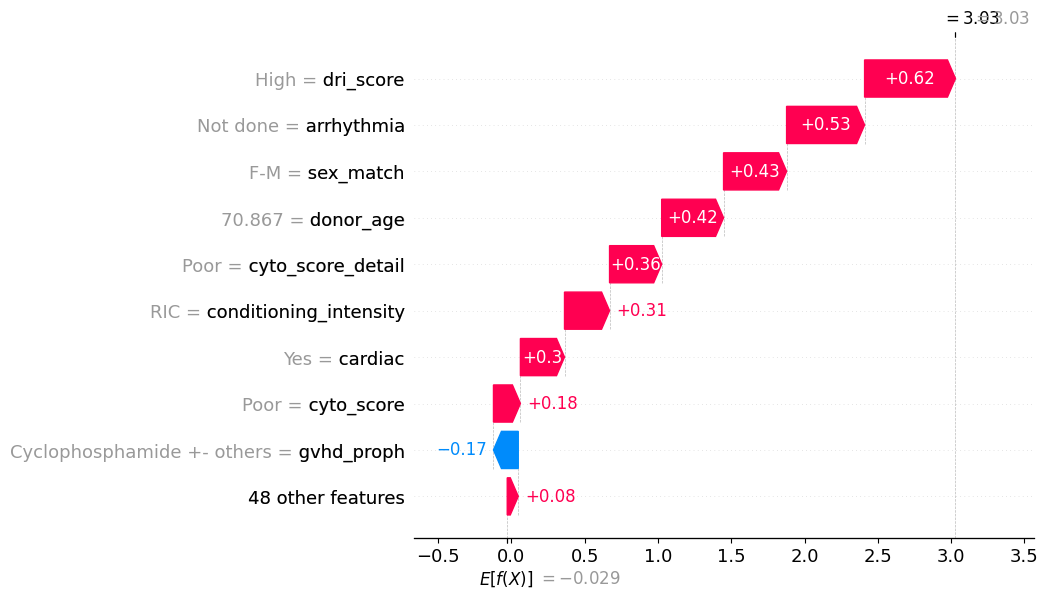

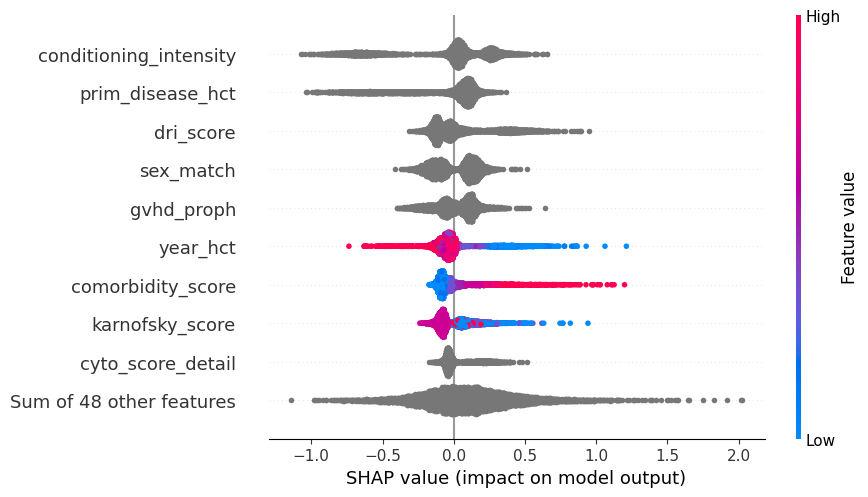

In [ ]:
# Explain model predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize first prediction explanation
shap.plots.waterfall(shap_values[0])

# Visualize global feature importance
shap.plots.beeswarm(shap_values)